### 7.7 稠密连接网络(DenseNet)

### 7.7.1 从ResNet到DenseNet

基于泰勒展开，可以把函数$f$分解为两个部分，同样的，可以将ResNet的函数展开。其在跨层连接上的主要区别如下图所示，也就是ResNet只连接到后面的一层，而DenseNet要连接到后面的所有层。

$$
f(\bm{x}) = \bm{x}+g(\bm{x})
$$

![](../images/7-7-1.svg)

下面这这张图更能直接说明DenseNet的连接方式。

![](../images/7-7-2.svg)

稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

### 7.7.2 稠密块体

DenseNet使用了ResNet改良版的“批量规范化->激活->卷积”的架构，下面先实现。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1),
    )

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。 然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(
                conv_block(num_channels * i + input_channels, num_channels)
            )
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            # 从第一个开始拖家带口接到后面
            X = torch.cat((X, Y), dim=1)
        return X

计算输出维度的时候需要注意，其是每个阶段输出之和，以上面为例，输入为3通道，第一个卷积层输出为10通道，第二个卷积层输出为10通道，最后的拼接结果为23通道。

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 7.7.3 过渡层

过渡层用来控制模型复杂度，通过$1\times 1$的卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽。

In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [5]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### 7.7.4 DenseNet模型

下面来构造DenseNet模型。

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

与ResNet一样，使用4个稠密块，并设置每个稠密块使用4个卷积层，从而与[7.6节](7-6.ipynb)中保持一致。同时在每个模块之间使用过渡层来减半高和宽，并减半通道数。

In [7]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [8]:
net = nn.Sequential(
    b1, 
    *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

### 7.7.5 训练模型

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。

loss 0.139, train acc 0.949, test acc 0.812
6604.4 examples/sec on cuda:1


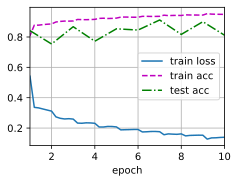

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7.7.7 小结

- 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
- DenseNet的主要构建模块是稠密块和过渡层。
- 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量。